<a href="https://colab.research.google.com/github/Bennybeams/UBISea/blob/main/Ketos_Detector_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ketos Detector Advanced

This file contains the study of the components of a Ketos detector.

**1. Install ketos and import needed packages**

In [ ]:
pip install ketos

     |████████████████████████████████| 171 kB 3.9 MB/s 
     |████████████████████████████████| 204 kB 43.0 MB/s 
  Created wheel for ketos: filename=ketos-2.2.0-py3-none-any.whl size=214619 sha256=585abd20ace5491b803ec407b6bee03c112e7bd89417f0fb9f69c647aa0a8249
  Stored in directory: /root/.cache/pip/wheels/73/52/97/5237b5daac8e54f4c96b8fbc2a2541e92d45368013cde742e4
  Created wheel for datetime-glob: filename=datetime_glob-1.0.8-py3-none-any.whl size=7980 sha256=917e032fc7ed3f283d45b4ba70950b47d18a9ccffebad3ee97febfd009c5e5a6
  Stored in directory: /root/.cache/pip/wheels/66/83/5f/fc21bcb17423bdbb629b5faea89d6307d6fc4b7f4976ded714
  Created wheel for lexery: filename=lexery-1.1.1-py3-none-any.whl size=4892 sha256=cb8a0a10fc7bea4f33640a261d42ba5f3b81fa5019973188a3cc83d01e6dc877
  Stored in directory: /root/.cache/pip/wheels/38/69/66/3916e07b71430a7628b43521720bc4a9d1a8d34f81843533f7
  Created wheel for version-parser: filename=version_parser-1.0.1-py3-none-any.whl size=4863 sha256=d7a

In [ ]:
import os
os.path
import pandas as pd
import ketos.neural_networks.dev_utils.detection as det
from ketos.audio.spectrogram import MagSpectrogram
from ketos.audio.audio_loader import AudioFrameLoader
from ketos.neural_networks.resnet import ResNetInterface
from ketos.neural_networks.dev_utils.detection import process, save_detections
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**2. Load the Classifier**

The Classifier contains a trained model based on neural network. It has to be trained with the sounds we want to detect.
Detector will get the sound files and sample it by sections of 3s, create spectrogram for each section and will send it to the model to be trained. Various options can be used on the detector to fine tune the detection (see Ketos Detector document)

First we need to move to our working directory which must contains :
- audio files folder
- trained model file (here narw.kt)
- the detector file (here detector.py)

In [ ]:
cd drive/MyDrive/Ketos_S21/

/content/drive/MyDrive/Ketos_S21


We load the trained classifier and the spectrogram parameters using the ResNetInterface.load_model_file method, as follows

In [ ]:
model, audio_repr = ResNetInterface.load_model_file(model_file='narw.kt', new_model_folder='./narw_tmp_folder', load_audio_repr=True)

Options of the ResNetInterface.load_model_file are the following :
- model_file : where to save trained model
- new_model_folder : temporary folder necessary for the process
- load_audio_repre : load model + spectrogram

Let's have a look to the spectrogram

In [ ]:
spec_config = audio_repr[0]['spectrogram']
spec_config

{'duration': 3.0,
 'freq_max': 500,
 'freq_min': 0,
 'rate': 1000,
 'step': 0.032,
 'type': 'MagSpectrogram',
 'window': 0.256,
 'window_func': 'hamming'}

Information found :
- Spectrogram Type : Magnitude Spectrogram
- Sampling rate of the audio signal : 1000 samples/s
- Window size (0.256 s)
- Step size (0.032 s)
- Minimum and maximum frequencies (0 and 500 Hz) 
- Window function (Hamming) 
- Duration of each clip (3.0 s)

**3. Test Data Analysis**

We have 3 wav files of 30mn long with 26 detectable events in total. We also have an annotation.csv file which record all the events and their happening time.

Let's have a look to the annotation.csv file.

In [ ]:
annot = pd.read_csv('data/annotations.csv', sep=';')
print(annot)

      sound_file  call_time
0   sample_1.wav   1128.840
1   sample_1.wav   1153.526
2   sample_1.wav   1196.778
3   sample_1.wav   1227.642
4   sample_1.wav   1358.181
5   sample_1.wav   1437.482
6   sample_1.wav   1489.288
7   sample_1.wav   1511.670
8   sample_1.wav   1530.595
9   sample_1.wav   1536.580
10  sample_1.wav   1714.372
11  sample_1.wav   1768.251
12  sample_1.wav   1777.835
13  sample_2.wav     68.149
14  sample_2.wav    688.507
15  sample_2.wav    755.940
16  sample_2.wav    770.440
17  sample_3.wav     68.853
18  sample_3.wav    105.927
19  sample_3.wav   1057.015
20  sample_3.wav   1067.282
21  sample_3.wav   1290.563
22  sample_3.wav   1378.955
23  sample_3.wav   1428.648
24  sample_3.wav   1663.622
25  sample_3.wav   1676.682


This file contains two column, one with the sound file and the second one with the time in second from the beginning of the file when the event occurs (as the event last some time we can consider this value as the middle point of the time the sound last).

We may want to have a temporal view of the events that we'll be able to compare with the detector's output:

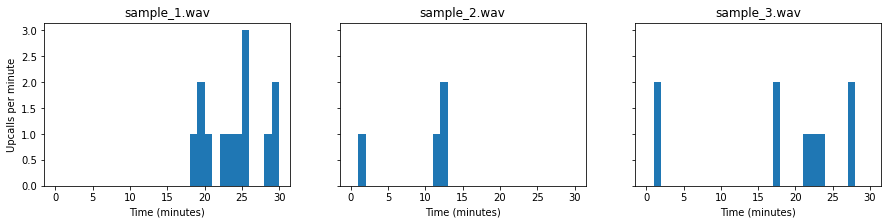

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15,3), sharey=True)

for i in range(3):
    filename = f'sample_{i+1}.wav' 
    values = annot[annot['sound_file']==filename]['call_time'].values / 60  #select the occurrence times for this file, and convert from seconds to minutes
    axes[i].hist(values, bins=30, range=(0,30)) #create the histogram
    axes[i].set_xlabel('Time (minutes)') #add legends
    if i==0: axes[i].set_ylabel('Upcalls per minute')
    axes[i].set_title(filename)

We can see that the three samples get events. Moreover we can see a tendancy for clustering (events are grouped).

We also may want to visualize the spectrogram of upcalls. To do so we can use the MagSpectrogram.from_wav function from Ketos package. We must use the same parameters as we use for the model.

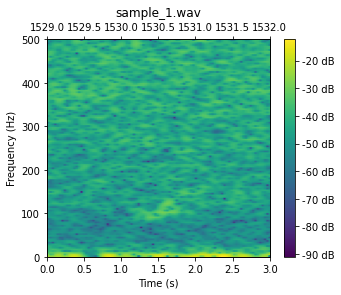

In [ ]:
# Create the spectrogram for the first wav file, with the same parameters as the model.
filename = f'sample_1.wav'
spec = MagSpectrogram.from_wav(path='data/audio/'+filename, 
                               offset=1530.5 - 0.5*spec_config['duration'],
                               **spec_config)
spec.plot(axes[i])
plt.show()

**4. Choose the right step size**

To optimize the detection we need to fine tune the parameters of the detector. One of the tricky value is the step_size.

Our samples are 3s long. So the step size should not be greater than 3s to avoid to miss events. Step size lower than 3s will cause overlapping.

It can be useful to overlap to be sure that an event is detected. Detector is able to detect that an event has been already detected and don't count it twice. However, big overlap will generate more samples and will increase the detection time.

In our case a step size of 1.5 looks to be an optimal value.